# MLP Scaling: $H$ vs $|G|$ 

Hidden neurons vs group size scaling experiments.

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "gagf"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Working directory:  /home/facosta/group-agf/gagf
Directory added to path:  /home/facosta/group-agf
Directory added to path:  /home/facosta/group-agf/gagf


## Specify experiment directory

In [4]:
sweep_dir = "/home/facosta/group-agf/sweeps/onehot_scaling_sweep_20251215_175955"
print(os.path.exists(sweep_dir))

True


### Steps to Convergence

In [5]:
def load_sweep_results_grid_convergence_p_h(
    sweep_dir: str, p_values: list, hidden_dims: list, reduction_threshold: float = 0.99
):
    """
    Load sweep results and compute steps to convergence for p vs hidden_dim sweep.

    Convergence is defined as reaching `reduction_threshold` loss reduction
    (e.g., 0.99 = 99% reduction from initial loss).

    If convergence is not reached, the grid point is set to NaN (blacked out).

    Args:
        sweep_dir: Path to the sweep directory
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        reduction_threshold: Fraction of loss reduction to consider converged

    Returns:
        grid: 2D array with mean steps to convergence (NaN if didn't converge)
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            exp_name = f"p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Collect convergence steps from all seeds
            convergence_steps = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    initial_loss = loss_history[0]

                    if initial_loss > 0:
                        # Compute reduction at each step
                        reductions = 1 - loss_history / initial_loss

                        # Find first step where reduction >= threshold
                        converged_mask = reductions >= reduction_threshold
                        if np.any(converged_mask):
                            step = np.argmax(converged_mask)  # First True
                            convergence_steps.append(step)
                        # else: Never converged - don't add to list

            if convergence_steps:
                grid[i, j] = np.mean(convergence_steps)
                std_grid[i, j] = (
                    np.std(convergence_steps) if len(convergence_steps) > 1 else 0.0
                )
            # else: No seeds converged - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

In [ ]:
# Define parameter values from the sweep config
p_values = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
    55,
    60,
    65,
    70,
    75,
    80,
    85,
    90,
    95,
    100,
]
hidden_dims = [
    30,
    60,
    90,
    120,
    150,
    180,
    210,
    240,
    270,
    300,
    330,
    360,
    390,
    420,
    450,
    480,
    510,
    540,
    570,
    600,
]

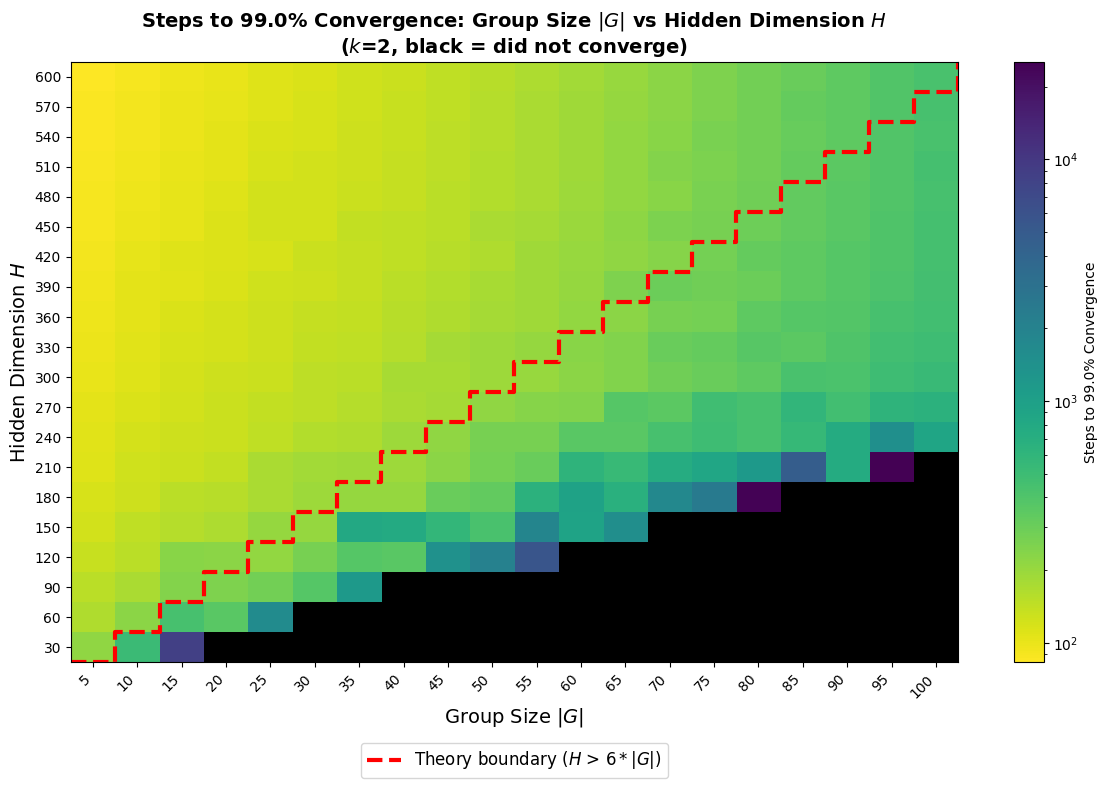

In [41]:
# Load convergence data
reduction_threshold = 0.99
conv_grid, conv_std = load_sweep_results_grid_convergence_p_h(
    sweep_dir, p_values, hidden_dims, reduction_threshold=reduction_threshold
)

# Plot convergence heatmap: p (group size) vs hidden_dim
from matplotlib.colors import LogNorm

plt.figure(figsize=(12, 8))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid, aspect="auto", cmap=cmap, norm=LogNorm())

plt.xlabel("Group Size $|G|$", fontsize=14)
plt.ylabel("Hidden Dimension $H$", fontsize=14)

# Set x-axis ticks (p values)
plt.xticks(range(len(p_values)), p_values, rotation=45, ha="right")

# Set y-axis ticks (hidden dimensions)
plt.yticks(range(len(hidden_dims)), hidden_dims)
plt.gca().invert_yaxis()

x_step = np.arange(len(p_values) + 1) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))  # Example: stays within bounds

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H$ > $6*|G|$)",
)

# Place legend outside the plot area (to the right)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True)


plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(
    f"Steps to {reduction_threshold*100}% Convergence: Group Size $|G|$ vs Hidden Dimension $H$\n($k$=2, black = did not converge)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

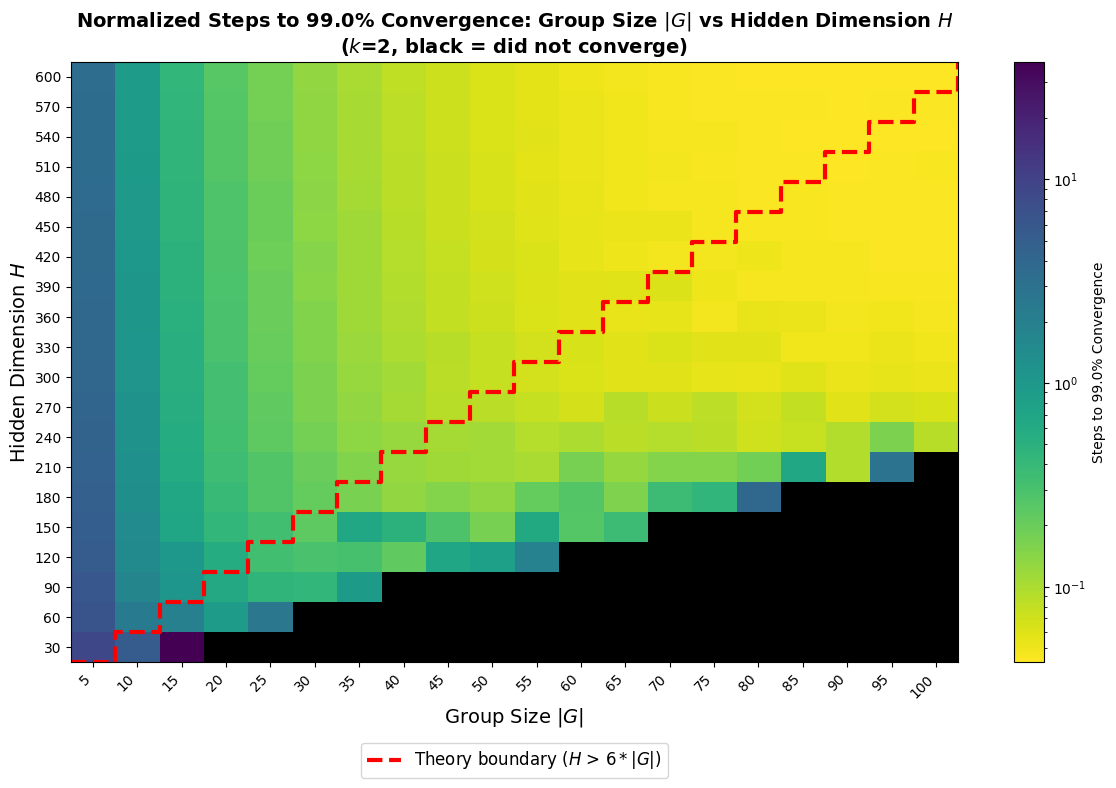

In [63]:
def load_sweep_results_grid_convergence_p_h(
    sweep_dir: str,
    p_values: list,
    hidden_dims: list,
    reduction_threshold: float = 0.99,
    normalize: bool = False,
):
    """
    Load sweep results and compute steps to convergence for p vs hidden_dim sweep.

    Convergence is defined as reaching `reduction_threshold` loss reduction
    (e.g., 0.99 = 99% reduction from initial loss).

    If convergence is not reached, the grid point is set to NaN (blacked out).

    Args:
        sweep_dir: Path to the sweep directory
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        reduction_threshold: Fraction of loss reduction to consider converged
        normalize: If True, divide steps by |G|^k (data space size).
                   For k=2, divides by p^2.

    Returns:
        grid: 2D array with mean steps to convergence (NaN if didn't converge)
              Shape: (len(hidden_dims), len(p_values))
              If normalize=True, values are steps / p^2
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            exp_name = f"p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Collect convergence steps from all seeds
            convergence_steps = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    initial_loss = loss_history[0]

                    if initial_loss > 0:
                        # Compute reduction at each step
                        reductions = 1 - loss_history / initial_loss

                        # Find first step where reduction >= threshold
                        converged_mask = reductions >= reduction_threshold
                        if np.any(converged_mask):
                            step = np.argmax(converged_mask)  # First True
                            convergence_steps.append(step)
                        # else: Never converged - don't add to list

            if convergence_steps:
                mean_steps = np.mean(convergence_steps)
                std_steps = (
                    np.std(convergence_steps) if len(convergence_steps) > 1 else 0.0
                )

                # Normalize by data space size if requested
                if normalize:
                    data_space_size = p**2  # For k=2
                    grid[i, j] = mean_steps / data_space_size
                    std_grid[i, j] = std_steps / data_space_size
                else:
                    grid[i, j] = mean_steps
                    std_grid[i, j] = std_steps
            # else: No seeds converged - grid[i,j] remains NaN (blacked out)

    return grid, std_grid


# Load convergence data
reduction_threshold = 0.99
conv_grid, conv_std = load_sweep_results_grid_convergence_p_h(
    sweep_dir,
    p_values,
    hidden_dims,
    reduction_threshold=reduction_threshold,
    normalize=True,
)

# Plot convergence heatmap: p (group size) vs hidden_dim
from matplotlib.colors import LogNorm

plt.figure(figsize=(12, 8))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid, aspect="auto", cmap=cmap, norm=LogNorm())

plt.xlabel("Group Size $|G|$", fontsize=14)
plt.ylabel("Hidden Dimension $H$", fontsize=14)

# Set x-axis ticks (p values)
plt.xticks(range(len(p_values)), p_values, rotation=45, ha="right")

# Set y-axis ticks (hidden dimensions)
plt.yticks(range(len(hidden_dims)), hidden_dims)
plt.gca().invert_yaxis()

x_step = np.arange(len(p_values) + 1) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))  # Example: stays within bounds

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H$ > $6*|G|$)",
)

# Place legend outside the plot area (to the right)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True)


plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(
    f"Normalized Steps to {reduction_threshold*100}% Convergence: Group Size $|G|$ vs Hidden Dimension $H$\n($k$=2, black = did not converge)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

### Training Instability

In [28]:
def load_sweep_results_grid_spikiness_p_h(
    sweep_dir: str,
    p_values: list,
    hidden_dims: list,
):
    """
    Compute fraction of training steps where loss increased (instability) for p vs h sweeps.

    Args:
        sweep_dir: Path to the sweep directory
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values

    Returns:
        grid: 2D array with mean frac_upward across seeds
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            exp_name = f"p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            frac_upwards = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    log_loss = np.log10(loss_history + 1e-10)
                    log_changes = np.diff(log_loss)

                    # Fraction of steps where loss went UP
                    frac_upward = np.sum(log_changes > 0) / len(log_changes)
                    frac_upwards.append(frac_upward)

            if frac_upwards:
                grid[i, j] = np.mean(frac_upwards)
                std_grid[i, j] = np.std(frac_upwards) if len(frac_upwards) > 1 else 0.0

    return grid, std_grid

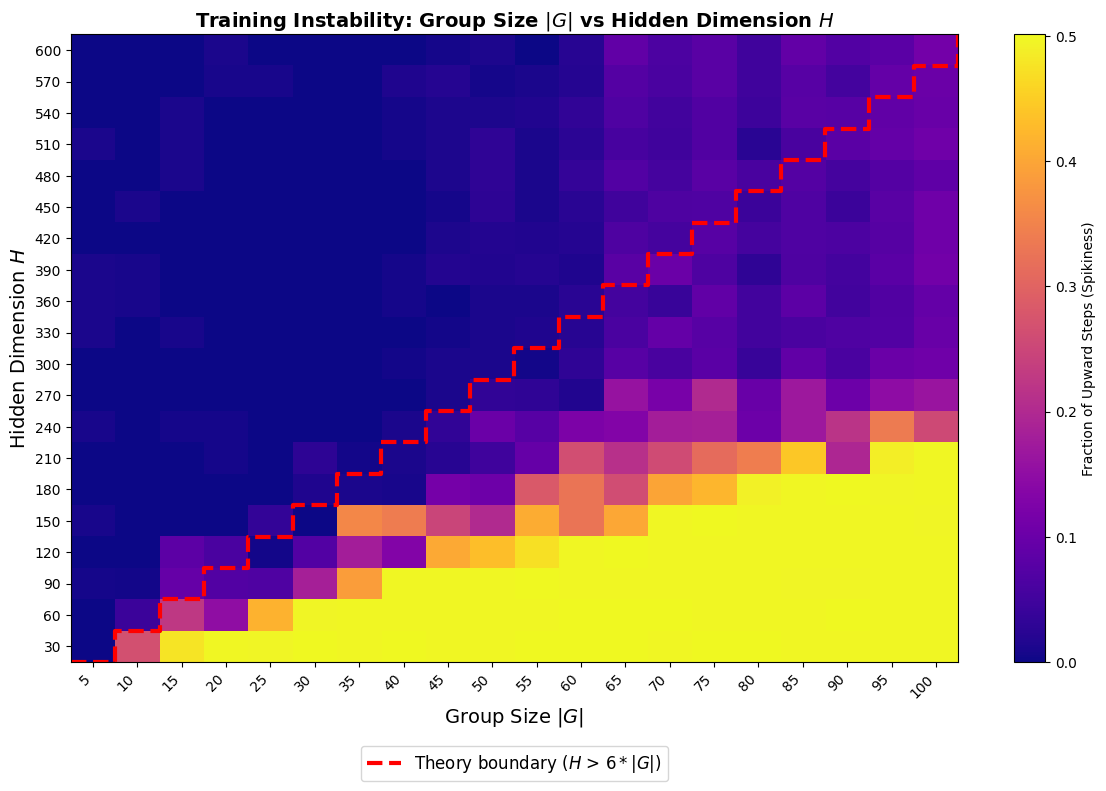

In [38]:
# Load spikiness data
spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
    sweep_dir, p_values, hidden_dims
)

# Plot
plt.figure(figsize=(12, 8))
plt.imshow(spike_grid_p, aspect="auto", cmap="plasma")
plt.xlabel("Group Size $|G|$", fontsize=14)
plt.ylabel("Hidden Dimension $H$", fontsize=14)
plt.xticks(range(len(p_values)), p_values, rotation=45, ha="right")
plt.yticks(range(len(hidden_dims)), hidden_dims)
plt.gca().invert_yaxis()


plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H$ > $6*|G|$)",
)

# Place legend outside the plot area (to the right)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True)

plt.colorbar(label="Fraction of Upward Steps (Spikiness)")
plt.title(
    "Training Instability: Group Size $|G|$ vs Hidden Dimension $H$",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

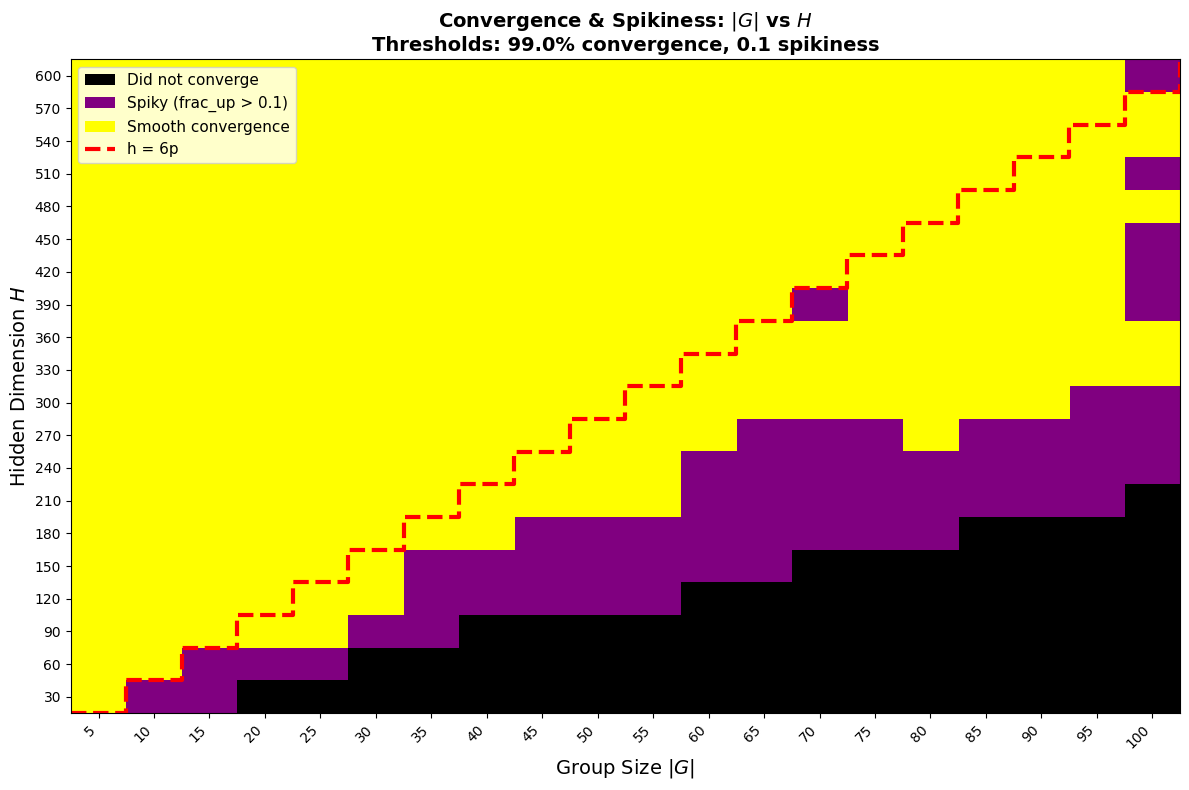

In [57]:
# Load both metrics
reduction_threshold = 0.99
spikiness_threshold = 0.1

conv_grid_p, conv_std_p = load_sweep_results_grid_convergence_p_h(
    sweep_dir, p_values, hidden_dims, reduction_threshold=reduction_threshold
)
spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
    sweep_dir, p_values, hidden_dims
)

# Create categorical grid: 0=black (no conv), 1=purple (spiky), 2=yellow (smooth)
category_grid = np.full((len(hidden_dims), len(p_values)), 0.0)  # Start with 0 (black)

for i in range(len(hidden_dims)):
    for j in range(len(p_values)):
        converged = not np.isnan(conv_grid_p[i, j])

        if converged:
            spiky = spike_grid_p[i, j] > spikiness_threshold
            if spiky:
                category_grid[i, j] = 1.0  # Purple (spiky)
            else:
                category_grid[i, j] = 2.0  # Yellow (smooth)
        # else stays 0.0 (black, did not converge)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Custom colormap: black -> purple -> yellow
from matplotlib.colors import ListedColormap

colors = ["black", "purple", "yellow"]
cmap = ListedColormap(colors)

im = ax.imshow(category_grid, aspect="auto", cmap=cmap, vmin=0, vmax=2)

ax.set_xlabel("Group Size $|G|$", fontsize=14)
ax.set_ylabel("Hidden Dimension $H$", fontsize=14)

# Set x-axis ticks (p values)
ax.set_xticks(range(len(p_values)))
ax.set_xticklabels(p_values, rotation=45, ha="right")

# Set y-axis ticks (hidden dimensions)
ax.set_yticks(range(len(hidden_dims)))
ax.set_yticklabels(hidden_dims)
ax.invert_yaxis()

# Add theory lines
p_indices = np.arange(len(p_values))

# Theory line 1: h = 6*p (linear scaling)
h_linear = [6 * p for p in p_values]
h_linear_indices = []
for h_val in h_linear:
    if h_val <= max(hidden_dims):
        idx = np.argmin(np.abs(np.array(hidden_dims) - h_val))
        h_linear_indices.append(idx)
    else:
        h_linear_indices.append(len(hidden_dims) - 1)

ax.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H$ > $6*|G|$)",
)


# Create custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="black", label="Did not converge"),
    Patch(facecolor="purple", label=f"Spiky (frac_up > {spikiness_threshold})"),
    Patch(facecolor="yellow", label="Smooth convergence"),
    plt.Line2D([0], [0], color="r", linewidth=3, linestyle="--", label="h = 6p"),
]

ax.legend(handles=legend_elements, loc="upper left", fontsize=11, frameon=True)

ax.set_title(
    f"Convergence & Spikiness: $|G|$ vs $H$\nThresholds: {reduction_threshold*100}% convergence, {spikiness_threshold} spikiness",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

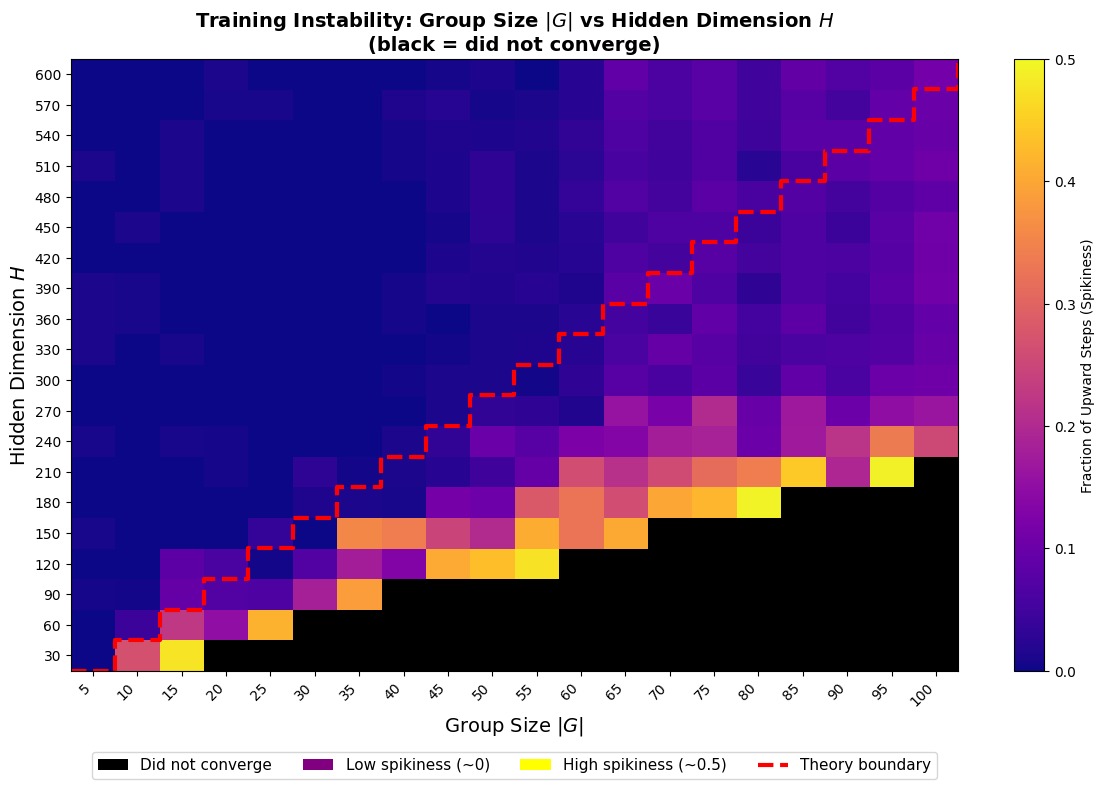

In [66]:
# Load both convergence and spikiness data
reduction_threshold = 0.99  # Or whatever threshold you used
conv_grid_p, conv_std_p = load_sweep_results_grid_convergence_p_h(
    sweep_dir, p_values, hidden_dims, reduction_threshold=reduction_threshold
)
spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
    sweep_dir, p_values, hidden_dims
)

# Mask spikiness grid: only show spikiness for converged runs
spike_grid_masked = spike_grid_p.copy()
for i in range(len(hidden_dims)):
    for j in range(len(p_values)):
        if np.isnan(conv_grid_p[i, j]):
            # Did not converge - set to NaN (will be black)
            spike_grid_masked[i, j] = np.nan

# Plot with masked spikiness
plt.figure(figsize=(12, 8))

# Use colormap with black for NaN
cmap_spike = plt.cm.plasma.copy()
cmap_spike.set_bad(color="black")

plt.imshow(spike_grid_masked, aspect="auto", cmap=cmap_spike, vmin=0, vmax=0.5)
plt.xlabel("Group Size $|G|$", fontsize=14)
plt.ylabel("Hidden Dimension $H$", fontsize=14)
plt.xticks(range(len(p_values)), p_values, rotation=45, ha="right")
plt.yticks(range(len(hidden_dims)), hidden_dims)
plt.gca().invert_yaxis()

# Add theory boundary
x_step = np.arange(len(p_values) + 1) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H$ > $6|G|$)",
)

# Custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="black", label="Did not converge"),
    Patch(facecolor="purple", label="Low spikiness (~0)"),
    Patch(facecolor="yellow", label="High spikiness (~0.5)"),
    plt.Line2D(
        [0], [0], color="red", linewidth=3, linestyle="--", label="Theory boundary"
    ),
]
plt.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    fontsize=11,
    frameon=True,
    ncol=4,
)

plt.colorbar(label="Fraction of Upward Steps (Spikiness)")
plt.title(
    "Training Instability: Group Size $|G|$ vs Hidden Dimension $H$\n(black = did not converge)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()